# NASA ABoVE Arctic Lakes ASD Data Processing
### ASD Data Processing
This code takes the raw output from three measurements ($L_{sky}, L_{ref}, L_{watersurface}$) collected using an ASD sensor and calculates downwelling irradiance ($E_d$), water-leaving radiance ($L_w$) and remote sensing reflectance ($R_{rs}$). 

**Authors:** Catherine Kuhn   
**Last Updated:** Nov 27th, 2018

In [1]:
### Import the required python libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import glob
import os
import sys
import csv
from scipy import interpolate
from os import listdir
from os.path import isfile, join
import matplotlib.gridspec as gridspec
#from pylr2 import regress2
import scipy.stats as stats
import seaborn as sns
import math

In [2]:
%matplotlib inline

In [3]:
%cd /Users/ckuhn/Downloads
df = pd.read_csv('processed_Data.csv', low_memory=False)

/Users/ckuhn/Downloads


In [4]:
print(df['rep_name'].unique())
df.head(1)

['sky' 'water' 'wr']


,rep_name,wavelength,asd_measure,std_deviation,lake_name
0,sky,350,1.663184,1.110763,9mile


## Calculate downwelling irradiance

Downwelling irrandiance ($E_d(\lambda)$) is calculated as: 

$E_d(\lambda)= L_{ref}(\lambda) * f_c * \pi  $  

where: 

- $E_d(\lambda)$ = downwelling irradiance   
- $L_{ref}(\lambda)$ = reference panel radiance  (wr measurement)  
- $f_c$ = correction factor ratio of field to lab radiance for Spectralon panel   

In [5]:
df = pd.read_csv('processed_Data.csv', low_memory=False)

def computeED (df):

    lakes = list(df['lake_name'].unique())
    wavelengths = list(df['wavelength'].unique())

    ed = []
    lref = []
    lake_name = []
    wls = []
    lsw = []
    lsky = []
    
    for lake in lakes:
        lake_df = df.loc[df['lake_name']==lake]
        for wavelength in wavelengths:
            new_df = lake_df.loc[lake_df['wavelength']==wavelength]
            name = new_df['lake_name'].head(1).item()
            wl = new_df['wavelength'].head(1).item()
            sky_df = new_df.loc[new_df['rep_name']=='sky']            
            sky = sky_df['asd_measure'].item()
            reference_df = new_df.loc[new_df['rep_name']=='wr']            
            ref = reference_df['asd_measure'].item()
            downwelling_irradiance = ref * 1 * math.pi
            water_df = new_df.loc[new_df['rep_name']=='water'] 
            water = water_df['asd_measure'].item()
            lsw.append(water)
            lsky.append(sky)
            ed.append(downwelling_irradiance)
            lref.append(ref)
            lake_name.append(name)
            wls.append(wl)
            
    lake_data = {}
    lake_data['ed'] = ed
    lake_data['lake_name'] = lake_name
    lake_data['lref'] = lref
    lake_data['lsky'] = lsky
    lake_data['lsw'] = lsw

    lake_data['wavelength'] = wls
    return pd.DataFrame.from_dict(lake_data)

In [6]:
done = computeED(df)

In [7]:
print(len(done))
print(done['lake_name'].unique())
done.head(2)

17208
['9mile' 'boot' 'cbdock' 'cbr' 'greenpepper' 'scoter' 'yf17' 'yf20']


,ed,lake_name,lref,lsky,lsw,wavelength
0,1.993682,9mile,0.634609,1.663184,0.046339,350
1,1.991035,9mile,0.633766,1.654474,0.046344,351


## Calculate water-leaving radiance

Water-leaving radiance ($L_w(\lambda)$) is calculated as: 

$L_w(\lambda)= L_{sw}(\lambda) - \rho_{air -sky}* L_{sky}(\lambda) $  

where: 

- $L_w(\lambda)$ = water-leaving radiance   
- $L_{sw}(\lambda)$ = total radiance measured above water
- $\rho_{air -sky}$ = sun and sky glint correction coefficient at the water surface (Mobley 1999)
- $L_{sky}(\lambda)$ - sky diffuse radiance

and    
$\rho_{air -sky} = \frac{L_{sky}(\lambda=750)}{E_{D}(\lambda=750)} \ge 0.05 \rightarrow 0.0256$

or     

$\rho_{air -sky} = \frac {L_{sky}(\lambda=750} {E_{D}(\lambda=750)} \lt 0.05 \rightarrow 0.0256 + 0.00039W + 0.000034W^2$       where  W is windspeed $(m s^{-1})$

##### Check Lsky to Ed ratios

In [8]:
#calculate the rho(water) - rho(air) using 750
nir = done.loc[done['wavelength']==750].copy()
nir['Lsky_Ed_ratio'] = nir['lsky']/nir['ed']
nir[['lake_name','Lsky_Ed_ratio']]
## Only one lake had Lsky:ED < 0.05, so we only need windspeed for that lake, which is 
#Greenpepper so that is the only one we need to do a custome rho value for 

,lake_name,Lsky_Ed_ratio
400,9mile,0.591414
2551,boot,0.114764
4702,cbdock,0.276833
6853,cbr,0.380883
9004,greenpepper,0.039728
11155,scoter,0.182353
13306,yf17,0.147105
15457,yf20,0.370676


##### Calculate water-leaving radiance

In [36]:
# Pass windspeed for the lake where the Lsky to Ed ratio < 0.05
# Greenpepper windspeed is 3.20 m s-1
windspeed =  3.2

def calculateLW(df):
    calcs = {}
    lakes = list(df['lake_name'].unique())
    wavelengths = list(df['wavelength'].unique())
    for lake in lakes: 
        lake_df = done[done['lake_name']==lake]
        #calculate the rho(water) - rho(air) using 750
        nir = lake_df[lake_df['wavelength']==750]
        nir['Lsky_Ed_ratio'] = nir['lsky']/nir['ed']
        if (nir['Lsky_Ed_ratio'].iloc[0] >=0.05):
            rho = 0.0256
            #print(rho)
        else: 
            rho = (0.0256 + (0.00039*windspeed) + (0.000034*windspeed**2))
        water_leaving_radiance = (lake_df['lsw'] - (lake_df['lsky'] * rho)).tolist()
        calcs[lake] = water_leaving_radiance
    return calcs

In [48]:
lw = calculateLW(done)
lw = pd.DataFrame.from_dict(lw)
wavelengths = done["wavelength"].unique().tolist()
lw["wavelengths"] = wavelengths
print('*************Dataframe of LW values*************')
lw.head(10)

/Users/ckuhn/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


*************Dataframe of LW values*************


,9mile,boot,cbdock,cbr,greenpepper,scoter,yf17,yf20,wavelengths
0,0.003762,-0.006005,-0.011381,0.006666,-0.023372,-0.004772,-0.005489,-0.039604,350
1,0.003990,-0.006083,-0.012384,0.007134,-0.023058,-0.004665,-0.005206,-0.039463,351
2,0.003794,-0.005868,-0.012036,0.006899,-0.023045,-0.004575,-0.005130,-0.039169,352
3,0.004002,-0.005976,-0.012387,0.006719,-0.022553,-0.004322,-0.004909,-0.038893,353
4,0.004226,-0.005984,-0.012449,0.006670,-0.022106,-0.004105,-0.004595,-0.038607,354
5,0.004198,-0.005702,-0.011606,0.006718,-0.022019,-0.004017,-0.004283,-0.038260,355
6,0.004421,-0.005813,-0.011147,0.006916,-0.021672,-0.003793,-0.003972,-0.037813,356
7,0.004370,-0.005807,-0.011066,0.006774,-0.021342,-0.003706,-0.003800,-0.037477,357
8,0.004315,-0.005729,-0.011238,0.006666,-0.021058,-0.003619,-0.003672,-0.037152,358
9,0.004541,-0.005713,-0.011361,0.006935,-0.020784,-0.003399,-0.003479,-0.036705,359


In [49]:
lw_values = (done['lsw'] - (done['lsky'] * 0.025))
print('number of negative values:', sum(1 for number in lw_values if number < 0))
print('number of positive values:', sum(1 for number in lw_values if number > 0))

number of negative values: 10647
number of positive values: 6561


### Calculate Remote Sensing Reflectance

Downwelling irrandiance ($E_d(\lambda)$) is calculated as: 

$R_{rs}(\lambda) = \frac{L_w(\lambda)}{E_d(\lambda)}$  

where: 

- $R_{rs}$ = remote sensing reflectance 
- $E_d(\lambda)$ = downwelling irradiance   
- $L_{w}(\lambda)$ = water-leaving radiance  

In [50]:
def calculateRRS(df1, df2):
    calcs = {}
    lakes = list(df1['lake_name'].unique())
    for lake in lakes:
        eds = df1[df1["lake_name"] == lake]
        rrs = np.array(df2[lake]) / np.array(eds['ed'])
        calcs[lake]=rrs
    return calcs 
# add back in as a new column to the dataframe

In [52]:
rrs = calculateRRS(done, lw)
rrs = pd.DataFrame.from_dict(rrs)
rrs['wavelength']= wavelengths
print('*************Dataframe of RRS values*************')
rrs.head(10)

*************Dataframe of RRS values*************


,9mile,boot,cbdock,cbr,greenpepper,scoter,yf17,yf20,wavelength
0,0.001887,-0.002037,-0.003578,0.002241,-0.007639,-0.001988,-0.001571,-0.015817,350
1,0.002004,-0.002065,-0.003893,0.002398,-0.007543,-0.001946,-0.001489,-0.015767,351
2,0.001909,-0.001992,-0.003784,0.002319,-0.007541,-0.001911,-0.001467,-0.015661,352
3,0.002016,-0.002029,-0.003895,0.002258,-0.007384,-0.001807,-0.001402,-0.015559,353
4,0.002132,-0.002033,-0.003915,0.002241,-0.007241,-0.001718,-0.001311,-0.015452,354
5,0.002121,-0.001937,-0.003650,0.002257,-0.007216,-0.001683,-0.001222,-0.015318,355
6,0.002236,-0.001976,-0.003505,0.002324,-0.007106,-0.001591,-0.001132,-0.015147,356
7,0.002213,-0.001975,-0.003480,0.002276,-0.007003,-0.001556,-0.001082,-0.015020,357
8,0.002189,-0.001949,-0.003535,0.002239,-0.006914,-0.001522,-0.001044,-0.014896,358
9,0.002306,-0.001944,-0.003574,0.002329,-0.006828,-0.001431,-0.000989,-0.014724,359


## Combine All Data Together

#### Make data from of lw and rrs

In [53]:
def appendNewData(df):
    calcs = {}
    for lake in lakes:
        df = done[done['lake_name']==lake]
        calcs['rrs']=rrs[lake]
        calcs['lw'] = lw[lake]
        calcs['lake_name'] = lake
    return calcs 

allNewData = appendNewData(done)

done2 = pd.DataFrame.from_dict(allNewData)
done2['wavelength']= wavelengths
print('*************Dataframe of RRS values*************')
print(len(done2))
print(done2['lake_name'].unique())
done2.head(2)

*************Dataframe of RRS values*************
2151
['yf20']


,rrs,lw,lake_name,wavelength
0,-0.015817,-0.039604,yf20,350
1,-0.015767,-0.039463,yf20,351


#### Join back to original df

In [54]:
mergedData = pd.merge(done, done2,  how='left', left_on=['lake_name','wavelength'], right_on = ['lake_name','wavelength'])
mergedData.head()

,ed,lake_name,lref,lsky,lsw,wavelength,rrs,lw
0,1.993682,9mile,0.634609,1.663184,0.046339,350,NaN,NaN
1,1.991035,9mile,0.633766,1.654474,0.046344,351,NaN,NaN
2,1.987809,9mile,0.632739,1.646593,0.045947,352,NaN,NaN
3,1.985196,9mile,0.631908,1.638355,0.045944,353,NaN,NaN
4,1.982534,9mile,0.631060,1.630276,0.045961,354,NaN,NaN


## Visualize New Rrs Data

No bueno. These are mostly negative

(350, 900)

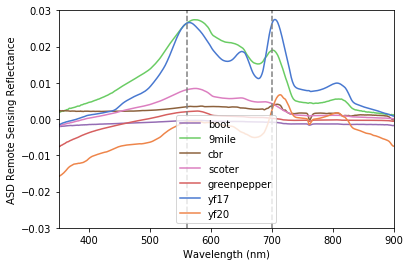

In [55]:
x = np.array(wavelengths)
sns.lineplot(x, y = 'boot', data = rrs, markers = True,  label = 'boot',color= '#956cb4', legend = False)
sns.lineplot(x, y = '9mile', data = rrs, markers = True, label = '9mile', color='#6acc64', legend = False)
sns.lineplot(x, y = 'cbr', data = rrs, markers = True, label = 'cbr', color='#8c613c' , legend = False)
sns.lineplot(x, y = 'scoter', data = rrs, markers = True, label = 'scoter',color='#dc7ec0', legend = False)
sns.lineplot(x, y = 'greenpepper', data = rrs, markers = True,  label = 'greenpepper', color='#d65f5f', legend = False)
sns.lineplot(x, y = 'yf17', data = rrs, markers = True, label = 'yf17', color='#4878d0', legend = False)
sns.lineplot(x, y = 'yf20', data = rrs, markers = True, label = 'yf20', color='#ee854a', legend = False)

plt.xlabel('Wavelength (nm)')
plt.ylabel('ASD Remote Sensing Reflectance')
plt.axvline(x=560, color= 'grey', linestyle = '--')
plt.axvline(x=700, color= 'grey', linestyle = '--')
plt.savefig('ASD_all_lakes_rrs.png', dpi= 300)
plt.legend()
plt.ylim(-0.03,0.03)
plt.xlim(350, 900)

### Water-leaving radiance (${L_w}$)

(350, 900)

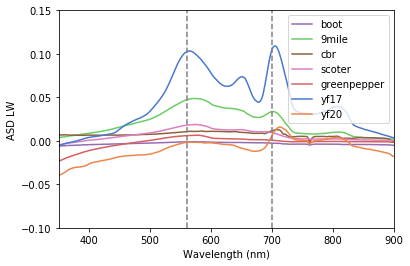

In [59]:
x = np.array(wavelengths)
sns.lineplot(x, y = 'boot', data = lw, markers = True,  label = 'boot',color= '#956cb4', legend = False)
sns.lineplot(x, y = '9mile', data = lw, markers = True, label = '9mile', color='#6acc64', legend = False)
sns.lineplot(x, y = 'cbr', data = lw, markers = True, label = 'cbr', color='#8c613c' , legend = False)
sns.lineplot(x, y = 'scoter', data = lw, markers = True, label = 'scoter',color='#dc7ec0', legend = False)
sns.lineplot(x, y = 'greenpepper', data = lw, markers = True,  label = 'greenpepper', color='#d65f5f', legend = False)
sns.lineplot(x, y = 'yf17', data = lw, markers = True, label = 'yf17', color='#4878d0', legend = False)
sns.lineplot(x, y = 'yf20', data = lw, markers = True, label = 'yf20', color='#ee854a', legend = False)

plt.xlabel('Wavelength (nm)')
plt.ylabel('ASD LW')
plt.axvline(x=560, color= 'grey', linestyle = '--')
plt.axvline(x=700, color= 'grey', linestyle = '--')
#plt.savefig('ASD_all_lakes_lw.png', dpi= 300)
plt.legend()
plt.ylim(-0.1,0.15)
plt.xlim(350, 900)

In [60]:
yf20 = done.loc[done["lake_name"]=='yf20']
yf17 = done.loc[done["lake_name"]=='yf17']
cbr = done.loc[done["lake_name"]=='cbr']
mile = done.loc[done["lake_name"]=='9mile']
green = done.loc[done["lake_name"]=='greenpepper']
scoter = done.loc[done["lake_name"]=='scoter']
boot = done.loc[done["lake_name"]=='boot']

### Downwelling irradiance (${E_d}$)

(350, 900)

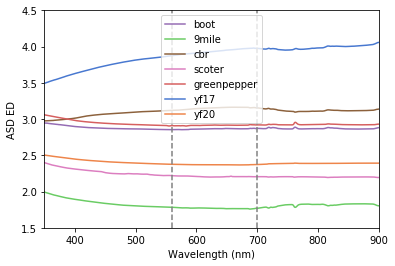

In [61]:
x = np.array(wavelengths)
sns.lineplot(x, y = 'ed', data = boot, markers = True,  label = 'boot',color= '#956cb4', legend = False)
sns.lineplot(x, y = 'ed', data = mile, markers = True, label = '9mile', color='#6acc64', legend = False)
sns.lineplot(x, y = 'ed', data = cbr, markers = True, label = 'cbr', color='#8c613c' , legend = False)
sns.lineplot(x, y = 'ed', data = scoter, markers = True, label = 'scoter',color='#dc7ec0', legend = False)
sns.lineplot(x, y = 'ed', data = green, markers = True,  label = 'greenpepper', color='#d65f5f', legend = False)
sns.lineplot(x, y = 'ed', data = yf17, markers = True, label = 'yf17', color='#4878d0', legend = False)
sns.lineplot(x, y = 'ed', data = yf20, markers = True, label = 'yf20', color='#ee854a', legend = False)

plt.xlabel('Wavelength (nm)')
plt.ylabel('ASD ED')
plt.axvline(x=560, color= 'grey', linestyle = '--')
plt.axvline(x=700, color= 'grey', linestyle = '--')
#plt.savefig('ASD_all_lakes_ed.png', dpi= 300)
plt.legend()
plt.ylim(1.5,4.5)
plt.xlim(350, 900)

### Reference measurement ($L_{ref}$)

In [ ]:
x = np.array(wavelengths)
sns.lineplot(x, y = 'lref', data = boot, markers = True,  label = 'boot',color= '#956cb4', legend = False)
sns.lineplot(x, y = 'lref', data = mile, markers = True, label = '9mile', color='#6acc64', legend = False)
sns.lineplot(x, y = 'lref', data = cbr, markers = True, label = 'cbr', color='#8c613c' , legend = False)
sns.lineplot(x, y = 'lref', data = scoter, markers = True, label = 'scoter',color='#dc7ec0', legend = False)
sns.lineplot(x, y = 'lref', data = green, markers = True,  label = 'greenpepper', color='#d65f5f', legend = False)
sns.lineplot(x, y = 'lref', data = yf17, markers = True, label = 'yf17', color='#4878d0', legend = False)
sns.lineplot(x, y = 'lref', data = yf20, markers = True, label = 'yf20', color='#ee854a', legend = False)

plt.xlabel('Wavelength (nm)')
plt.ylabel('ASD Lref')
plt.axvline(x=560, color= 'grey', linestyle = '--')
plt.axvline(x=700, color= 'grey', linestyle = '--')
#plt.savefig('ASD_all_lakes_lref.png', dpi= 300)
plt.legend()
plt.ylim(0,2)
plt.xlim(350, 900)

### Reference measurement ($L_{sky}$)

(350, 900)

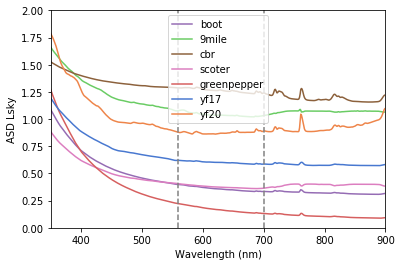

In [63]:
x = np.array(wavelengths)
sns.lineplot(x, y = 'lsky', data = boot, markers = True,  label = 'boot',color= '#956cb4', legend = False)
sns.lineplot(x, y = 'lsky', data = mile, markers = True, label = '9mile', color='#6acc64', legend = False)
sns.lineplot(x, y = 'lsky', data = cbr, markers = True, label = 'cbr', color='#8c613c' , legend = False)
sns.lineplot(x, y = 'lsky', data = scoter, markers = True, label = 'scoter',color='#dc7ec0', legend = False)
sns.lineplot(x, y = 'lsky', data = green, markers = True,  label = 'greenpepper', color='#d65f5f', legend = False)
sns.lineplot(x, y = 'lsky', data = yf17, markers = True, label = 'yf17', color='#4878d0', legend = False)
sns.lineplot(x, y = 'lsky', data = yf20, markers = True, label = 'yf20', color='#ee854a', legend = False)

plt.xlabel('Wavelength (nm)')
plt.ylabel('ASD Lsky')
plt.axvline(x=560, color= 'grey', linestyle = '--')
plt.axvline(x=700, color= 'grey', linestyle = '--')
#plt.savefig('ASD_all_lakes_lsky.png', dpi= 300)
plt.legend()
plt.ylim(0,2)
plt.xlim(350, 900)

### Above water total radiance measurement ($L_{sw}$)

(350, 900)

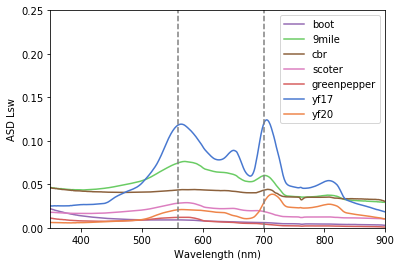

In [69]:
x = np.array(wavelengths)
sns.lineplot(x, y = 'lsw', data = boot, markers = True,  label = 'boot',color= '#956cb4', legend = False)
sns.lineplot(x, y = 'lsw', data = mile, markers = True, label = '9mile', color='#6acc64', legend = False)
sns.lineplot(x, y = 'lsw', data = cbr, markers = True, label = 'cbr', color='#8c613c' , legend = False)
sns.lineplot(x, y = 'lsw', data = scoter, markers = True, label = 'scoter',color='#dc7ec0', legend = False)
sns.lineplot(x, y = 'lsw', data = green, markers = True,  label = 'greenpepper', color='#d65f5f', legend = False)
sns.lineplot(x, y = 'lsw', data = yf17, markers = True, label = 'yf17', color='#4878d0', legend = False)
sns.lineplot(x, y = 'lsw', data = yf20, markers = True, label = 'yf20', color='#ee854a', legend = False)

plt.xlabel('Wavelength (nm)')
plt.ylabel('ASD Lsw')
plt.axvline(x=560, color= 'grey', linestyle = '--')
plt.axvline(x=700, color= 'grey', linestyle = '--')
#plt.savefig('ASD_all_lakes_lsw.png', dpi= 300)
plt.legend()
plt.ylim(0,0.25)
plt.xlim(350, 900)

In [ ]:
model_inputs = done.groupby('lake_name')['lref', 'lsw', 'lsky'].mean().reset_index()
model_inputs['Lsw-Lsky'] = (model_inputs['lsw']- (model_inputs['lsky']*0.0256))
model_inputs